# Plot of input flux for modern Earth, Archean Earth, and Proxima Centuri b 
Spectral files from ROCKE-3D database:https://portal.nccs.nasa.gov/GISS_modelE/ROCKE-3D/).
Comparisons to stellar black body spectrums included.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import math
import matplotlib.pyplot as plt
import iris # install with: conda install -c conda-forge iris
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from iris.analysis.cartography import cosine_latitude_weights
import os
import math
from aeolus.coord import ensure_bounds

In [2]:
um_data_dir = "/data/biogeochemdata/mphys2022/tidally_locked_data/ProCb_archean10pctCO2/data/"
plot_dir = "/data/jwm212/plots/"

In [3]:
def Earth_Flux(flux_file):
    file = open(flux_file,"r")
    f = file.readlines()
    wvlngth = []
    flux = []
    for i in f:
        wvlngth.append(i.split(' ')[5])
        flux.append(i.split(' ')[10])
    file.close()
    
    wvlngth = np.array([float(x) for x in wvlngth])
    flux = [x.replace("\n","") for x in flux]
    flux = np.array([float(x) for x in flux])
    flux = flux/((1.23**2)*(1e6)) #Units Conversion to W/m^2/um
    
    return wvlngth, flux

In [4]:
def Archean_Flux(flux_file):
    file = open(flux_file,"r")
    f = file.readlines()
    wvlngth = []
    flux = []
    for i in f:
        wvlngth.append(i.split('\t')[0])
        flux.append(i.split('\t')[1])
        
    file.close()

    wvlngth = np.array([float(x) for x in wvlngth])/1000
    
    flux = [x.replace("\n", "") for x in flux]
    flux = [x.replace("\t", "") for x in flux]
    flux = np.array([float(x) for x in flux])

    flux = flux/(1.23**2) #Units to W/m^2/um
    
    return wvlngth, flux

In [5]:
def Procb_Flux(flux_file):
    file = open(flux_file,"r")
    f = file.readlines()
    wvlngth = []
    flux = []
    for i in f:
        wvlngth.append(i.split(' ')[0])
        flux.append(i.split(' ')[1])
        
    file.close()

    wvlngth = np.array([float(x) for x in wvlngth])
    wvlngth = wvlngth*(1e-6)

    flux = [x.replace("\n", "") for x in flux]
    flux = np.array([float(x) for x in flux])
    
    flux = flux/(0.05**2) #Units to W/m^2/um
    
    return wvlngth, flux

In [6]:
def Planck(T,ratio,w_range):
    h = 6.626e-34 # Planck's Constant
    c = 3e8 # speed of light
    k = 1.38066e-23 # Boltzmann constant in J/K
    
    # spectral radiance
    p = (2*h*c*c)/(w_range**5)
    bb = p/(math.e**(h*c/(w_range*k*T))-1)
    bb = (1e-6)*bb
    
    bb = bb*ratio  # multiply by the square of the ratio of the solar radius of earth's
                   # orbital radius
    
    bb = bb*math.pi
    
    return bb

In [7]:
solar_file = '/home/jwm212/um/solar_flux_density.txt'
archean_solar_file = '/home/jwm212/um/solar_flux_density_Archean.txt'
procb_file = '/home/jwm212/um/proc_flux_density.txt'

earth_w = Earth_Flux(solar_file)[0]
archean_w = Archean_Flux(archean_solar_file)[0]
procb_w = Procb_Flux(procb_file)[0]

earth_flux = Earth_Flux(solar_file)[1]
archean_flux = Archean_Flux(archean_solar_file)[1]
procb_flux = Procb_Flux(procb_file)[1]

In [8]:
w_range = np.arange(0.1e-6, 10e-6, 10e-9)
b3042 = Planck(3042,2.058e-4,w_range)
b5780 = Planck(5780,1.43e-5,w_range)
b5660 = Planck(5660,1.43e-5,w_range)

In [9]:
base_name = "archean_ProC_b_muscles_10pctCO2_0pctCH4*"

surface_sw_up = "m01s01i509" # surface upward sw flux on bands
surface_sw_down = "m01s01i510" # surface downward sw flux on bands
varnames = [
    surface_sw_down,
    surface_sw_up,
]
cubes = {}

for varname in varnames:
    filename = um_data_dir+base_name
    cubes[varname] = iris.load_cube(filename,varname)
    cubes[varname] = cubes[varname].collapsed( # take time average
        ('time'), iris.analysis.MEAN
    )
    print(cubes[varname]) # see what the data cube looks like
#     print(cubes[varname].coord('longitude').points)
#     print(cubes[varname].coord('latitude').points)
    #cubes[varname] = roll_cube_pm180(cubes[varname])
    ensure_bounds(cubes[varname])
#     print(cubes[varname].coord('longitude').points)
    cubes[varname] = cubes[varname].extract( # constrain longitude so only have dayside
        iris.Constraint(longitude=lambda cell: cell>=-89.0 and cell <=89.0)
    )
    

m01s01i510 / (unknown)              (pseudo_level: 16; latitude: 90; longitude: 144)
    Dimension coordinates:
        pseudo_level                             x             -              -
        latitude                                 -             x              -
        longitude                                -             -              x
    Scalar coordinates:
        forecast_period             94080.0 hours, bound=(80640.0, 107520.0) hours
        forecast_reference_time     2066-01-18 09:00:00
        level_height                9.997773008299975 m, bound=(0.0, 20.001837881299945) m
        model_level_number          1
        sigma                       0.9988518204273017, bound=(1.0, 0.9977035784342132)
        time                        2076-10-12 09:00:00, bound=(2075-04-01 09:00:00, 2078-04-25 09:00:00)
    Cell methods:
        mean                        time (1 hour)
        mean                        time
    Attributes:
        STASH                       m

In [10]:
base_name = "archean_ProC_b_muscles_10pctCO2_0pctCH4*"

# Find data files from last timeslice ('4368' in filename)
import fnmatch

data_files = []
for file in os.listdir(um_data_dir):
    if fnmatch.fnmatch(file, '*4368*'):
        data_files.append(file)

data_files.sort()

# Load each data file into a list of Iris cubes, and show cubes (variables)
for data_file in data_files:
    cubes = iris.load(os.path.join(um_data_dir, data_file))
    

In [11]:
print(cubes)

0: air_temperature / (K)               (model_level_number: 50; latitude: 90; longitude: 144)


In [10]:
#surf_sw_down_flux = "surface_shortwave_downward_flux"

#cubes = {}
cube_flux = cubes[surface_sw_down]
#print(flux)
#pressure = cubes[air_pressure]
fmax = cube_flux.collapsed(("model_level_number","latitude","longitude"), iris.analysis.MAX).data
weights = cosine_latitude_weights(cube_flux)
levels1 = cube_flux.collapsed( # then average over longitude and latitude to get dayside mean flux
    ('latitude','longitude'), iris.analysis.MEAN, weights=weights
).data
print(levels1)
print(cube_flux.coord('pseudo_level').points*cube_flux.coord('level_height').points)
#cubes[varname] = interp_cube_from_height_to_pressure_levels(cubes[varname],pressure,levels)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.22081119e-06 7.45833887e-06 9.13885215e-05
 3.37029046e-04 1.15430223e-03 5.34522076e-04 2.68610138e-01
 1.47927377e+00 2.89119281e+01 1.18195710e+01 4.54580424e-01]
[  9.99777301  19.99554602  29.99331902  39.99109203  49.98886504
  59.98663805  69.98441106  79.98218407  89.97995707  99.97773008
 109.97550309 119.9732761  129.97104911 139.96882212 149.96659512
 159.96436813]


In [11]:
wavelength_um = np.array([5.000000000E-10, 7.500000000E-08, 7.500000000E-08, 1.000000000E-07, 1.000000000E-07, 1.250000000E-07, 1.250000000E-07, 1.500000000E-07,
                       1.500000000E-07, 1.750000000E-07, 1.750000000E-07, 2.000000000E-07, 2.000000000E-07, 2.250000000E-07, 2.250000000E-07, 2.500000000E-07,
                       2.500000000E-07, 2.750000000E-07, 2.750000000E-07, 3.000000000E-07, 3.000000000E-07, 3.200000000E-07, 3.200000000E-07, 5.050000000E-07,
                       5.050000000E-07, 6.900000000E-07, 6.900000000E-07, 1.190000000E-06, 1.190000000E-06, 2.380000000E-06, 2.380000000E-06, 1.000000000E-05])
fmax = np.array([val for val in fmax for _ in (0, 1)])
print(fmax)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.31459700e-06 6.31459700e-06
 2.18707023e-05 2.18707023e-05 2.47154179e-04 2.47154179e-04
 7.98905832e-04 7.98905832e-04 2.47614136e-03 2.47614136e-03
 9.22811939e-04 9.22811939e-04 4.87312440e-01 4.87312440e-01
 2.83360072e+00 2.83360072e+00 5.16278274e+01 5.16278274e+01
 2.19681801e+01 2.19681801e+01 1.02692828e+00 1.02692828e+00]


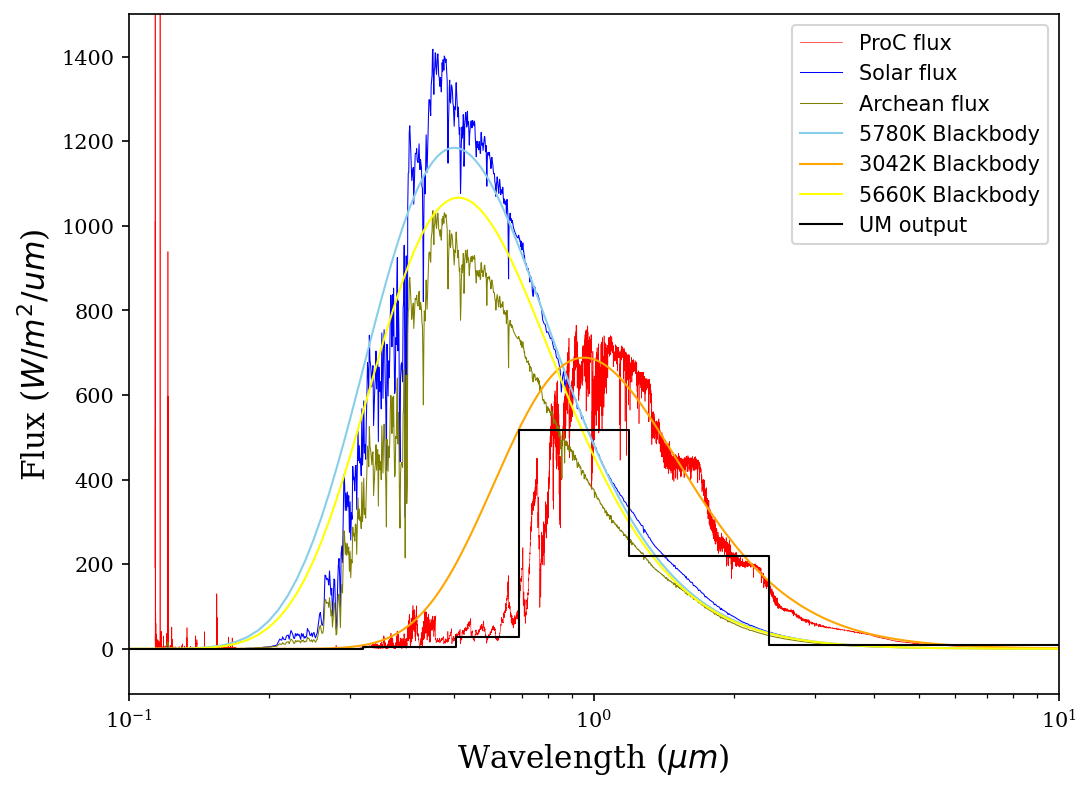

In [17]:
fig = plt.figure(figsize=(8, 6), dpi= 150, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)

ax.plot(procb_w*1e6, procb_flux, color='red', linewidth=0.3, label='ProC flux')
ax.plot(earth_w*1e6,earth_flux,color='blue', linewidth=0.5, label='Solar flux')
ax.plot(archean_w,archean_flux,color='olive', linewidth=0.5, label='Archean flux')

ax.plot(w_range*1e6,b5780,color='skyblue', linewidth=1, label='5780K Blackbody')
ax.plot(w_range*1e6,b3042,color='orange', linewidth=1, label='3042K Blackbody')
ax.plot(w_range*1e6,b5660,color='yellow', linewidth=1, label='5660K Blackbody')
ax.plot(wavelength_um*1e6,fmax*10,color='black', linewidth=1, label='UM output')

ax.set_axisbelow(True)
#for axis in ['top','bottom','left','right']:
#  ax.spines[axis].set_linewidth(3)

for tick in ax.get_xticklabels():
    tick.set_fontname("Serif")
for tick in ax.get_yticklabels():
    tick.set_fontname("Serif")
    
#ax.xaxis.set_tick_params(width=3)
#ax.yaxis.set_tick_params(width=3)
ax.set_xscale('log')
ax.set_ylim(ymax=1500)
ax.set_xlim(xmin=0.1,xmax=10)
#ax.set_yscale('log')
plt.xlabel('Wavelength ($\mu m$)', fontname='Serif', fontsize=15)
plt.ylabel('Flux ($W/m^2/um$)', fontname='serif', fontsize=15)
plt.legend()
plt.savefig(os.path.join(plot_dir,"Flux_comparison.jpg"))
plt.show()